<a href="https://colab.research.google.com/github/dk-wei/ml-algo-implementation/blob/main/Imbalanced_Learning_Method_Comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
%matplotlib inline


# Fitting model on imbalanced datasets and how to fight bias

This example illustrates the problem induced by learning on datasets having
imbalanced classes. Subsequently, we compare different approaches alleviating
these negative effects.


In [49]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

In [50]:
pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.7/dist-packages (0.8.0)


In [51]:
print(__doc__)

Automatically created module for IPython interactive environment


## Problem definition

We are dropping the following features:

- "fnlwgt": this feature was created while studying the "adult" dataset.
  Thus, we will not use this feature which is not acquired during the survey.
- "education-num": it is encoding the same information than "education".
  Thus, we are removing one of these 2 features.



In [52]:
from sklearn.datasets import fetch_openml

df, y = fetch_openml("adult", version=2, as_frame=True, return_X_y=True)
df = df.drop(columns=["fnlwgt", "education-num"])

In [53]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,Some-college,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


The "adult" dataset as a class ratio of about 3:1



In [54]:
classes_count = y.value_counts()
classes_count

<=50K    37155
>50K     11687
Name: class, dtype: int64

This dataset is only slightly imbalanced. To better highlight the effect of
learning from an imbalanced dataset, we will increase its ratio to 30:1



In [55]:
# make_imbalance可以创造imbalanced dataset
from imblearn.datasets import make_imbalance

ratio = 30
df_res, y_res = make_imbalance(
    df,
    y,
    sampling_strategy={classes_count.idxmin(): classes_count.max() // ratio},
)
y_res.value_counts()

<=50K    37155
>50K      1238
Name: class, dtype: int64

We will perform a cross-validation evaluation to get an estimate of the test
score.

As a baseline, we could use a classifier which will **always predict the
majority class independently of the features provided**.



In [56]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
scoring = ["accuracy", "balanced_accuracy"]
cv_result = cross_validate(dummy_clf, df_res, y_res, scoring=scoring)
print(f"Accuracy score of a dummy classifier: {cv_result['test_accuracy'].mean():.3f}")

Accuracy score of a dummy classifier: 0.968


Instead of using the accuracy, we can use the balanced accuracy which will
take into account the balancing issue.



In [57]:
cv_result

{'fit_time': array([0.01724768, 0.01569963, 0.01571703, 0.01582074, 0.01641178]),
 'score_time': array([0.03610206, 0.03483963, 0.03532028, 0.03472543, 0.04445076]),
 'test_accuracy': array([0.96770413, 0.96770413, 0.96770413, 0.96783016, 0.96783016]),
 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5, 0.5])}

In [58]:
print(
    f"Balanced accuracy score of a dummy classifier: "
    f"{cv_result['test_balanced_accuracy'].mean():.3f}"
)

Balanced accuracy score of a dummy classifier: 0.500


## Strategies to learn from an imbalanced dataset
We will use a dictionary and a list to continuously store the results of
our experiments and show them as a pandas dataframe.



In [59]:
index = []
scores = {"Accuracy": [], "Balanced accuracy": []}

### Dummy baseline

Before to train a real machine learning model, we can store the results
obtained with our :class:`~sklearn.dummy.DummyClassifier`.



In [60]:
import pandas as pd

index += ["Dummy classifier"]
cv_result = cross_validate(dummy_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.5


### Linear classifier baseline

We will create a machine learning pipeline using a
:class:`~sklearn.linear_model.LogisticRegression` classifier. In this regard,
we will need to one-hot encode the categorical columns and standardized the
numerical columns before to inject the data into the
:class:`~sklearn.linear_model.LogisticRegression` classifier.

First, we define our numerical and categorical pipelines.



In [61]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

num_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

Then, we can create a preprocessor which will dispatch the categorical
columns to the categorical pipeline and the numerical columns to the
numerical pipeline



In [62]:
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector

preprocessor_linear = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

Finally, we connect our preprocessor with our
:class:`~sklearn.linear_model.LogisticRegression`. We can then evaluate our
model.



In [63]:
from sklearn.linear_model import LogisticRegression

lr_clf = make_pipeline(preprocessor_linear, LogisticRegression(max_iter=1000))

In [64]:
index += ["Logistic regression"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.50000
Logistic regression,0.970125,0.56213


We can see that our linear model is learning slightly better than our dummy
baseline. However, it is impacted by the class imbalance.

We can verify that something similar is happening with a tree-based model
such as :class:`~sklearn.ensemble.RandomForestClassifier`. With this type of
classifier, we will not need to scale the numerical data, and we will only
need to ordinal encode the categorical data.



In [65]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

num_pipe = SimpleImputer(strategy="mean", add_indicator=True)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
)

preprocessor_tree = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

rf_clf = make_pipeline(
    preprocessor_tree, RandomForestClassifier(random_state=42, n_jobs=2)
)

In [66]:
index += ["Random forest"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.50000
Logistic regression,0.970125,0.56213
Random forest,0.970594,0.62756


The :class:`~sklearn.ensemble.RandomForestClassifier` is as well affected by
the class imbalanced, slightly less than the linear model. Now, we will
present different approach to improve the performance of these 2 models.

### Use `class_weight` method in Scikit-learn

Most of the models in `scikit-learn` have a parameter `class_weight`. **This
parameter will affect the computation of the loss in linear model or the
criterion in the tree-based model to penalize differently a false
classification from the minority and majority class (改变的是loss function和cross entropy的weights)**. We can set
`class_weight="balanced"` such that the weight applied is inversely
proportional to the class frequency. We test this parametrization in both
linear model and tree-based model.



In [67]:
lr_clf.set_params(logisticregression__class_weight="balanced")

index += ["Logistic regression with balanced class weights"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.50000
Logistic regression,0.970125,0.56213
Random forest,0.970594,0.62756
Logistic regression with balanced class weights,0.800849,0.81785


In [68]:
rf_clf.set_params(randomforestclassifier__class_weight="balanced")

index += ["Random forest with balanced class weights"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.500000
Logistic regression,0.970125,0.562130
Random forest,0.970594,0.627560
Logistic regression with balanced class weights,0.800849,0.817850
Random forest with balanced class weights,0.963561,0.627059


We can see that **using `class_weight` was really effective for the linear
model, alleviating the issue of learning from imbalanced classes**. However,
the :class:`~sklearn.ensemble.RandomForestClassifier` is still biased toward
the majority class, mainly due to the criterion which is not suited enough to
fight the class imbalance.

**对Linear model的影响效果更大，对random forest model的反而不起什么作用。**


### Resample the training set during learning (oversampling ^ undersampling)

Another way is to resample the training set by **single** under-sampling or
over-sampling some of the samples. `imbalanced-learn` provides some samplers
to do such processing.



In [69]:
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler

lr_clf = make_pipeline_with_sampler(
    preprocessor_linear,
    RandomUnderSampler(random_state=42),
    LogisticRegression(max_iter=1000),
)

In [70]:
index += ["Under-sampling + Logistic regression"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.500000
Logistic regression,0.970125,0.562130
Random forest,0.970594,0.627560
Logistic regression with balanced class weights,0.800849,0.817850
Random forest with balanced class weights,0.963561,0.627059
Under-sampling + Logistic regression,0.794624,0.818145


In [71]:
rf_clf = make_pipeline_with_sampler(
    preprocessor_tree,
    RandomUnderSampler(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=2),
)

In [72]:
index += ["Under-sampling + Random forest"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.500000
Logistic regression,0.970125,0.562130
Random forest,0.970594,0.627560
Logistic regression with balanced class weights,0.800849,0.817850
Random forest with balanced class weights,0.963561,0.627059
Under-sampling + Logistic regression,0.794624,0.818145
Under-sampling + Random forest,0.793374,0.807355


**Applying a random under-sampler before the training of the linear model or
random forest, allows to not focus on the majority class at the cost of
making more mistake for samples in the majority class (i.e. decreased
accuracy)**.

We could apply any type of samplers and find which sampler is working best
on the current dataset.

Instead, we will present another way by using classifiers which will apply
sampling internally.

### Use of specific balanced algorithms from imbalanced-learn

We already showed that random under-sampling can be effective on decision
tree. However, instead of under-sampling **once** the dataset, one could
under-sample the original dataset before to take a bootstrap sample. This is
the base of the :class:`imblearn.ensemble.BalancedRandomForestClassifier` and
:class:`~imblearn.ensemble.BalancedBaggingClassifier`.



In [73]:
from imblearn.ensemble import BalancedRandomForestClassifier

rf_clf = make_pipeline(
    preprocessor_tree,
    BalancedRandomForestClassifier(random_state=42, n_jobs=2),
)

In [74]:
index += ["Balanced random forest"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.500000
Logistic regression,0.970125,0.562130
Random forest,0.970594,0.627560
Logistic regression with balanced class weights,0.800849,0.817850
Random forest with balanced class weights,0.963561,0.627059
Under-sampling + Logistic regression,0.794624,0.818145
Under-sampling + Random forest,0.793374,0.807355
Balanced random forest,0.787591,0.819588


The performance with the
:class:`~imblearn.ensemble.BalancedRandomForestClassifier` is better than
applying a single random under-sampling. We will use a gradient-boosting
classifier within a :class:`~imblearn.ensemble.BalancedBaggingClassifier`.



In [75]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

bag_clf = make_pipeline(
    preprocessor_tree,
    BalancedBaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(random_state=42),
        n_estimators=10,
        random_state=42,
        n_jobs=2,
    ),
)

index += ["Balanced bag of histogram gradient boosting"]
cv_result = cross_validate(bag_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.500000
Logistic regression,0.970125,0.562130
Random forest,0.970594,0.627560
Logistic regression with balanced class weights,0.800849,0.817850
Random forest with balanced class weights,0.963561,0.627059
Under-sampling + Logistic regression,0.794624,0.818145
Under-sampling + Random forest,0.793374,0.807355
Balanced random forest,0.787591,0.819588
Balanced bag of histogram gradient boosting,0.835491,0.822470


This last approach is the most effective. The different under-sampling allows
to bring some diversity for the different GBDT to learn and not focus on a
portion of the majority class.



# Imbalanced Learning w/o Pipeline

## 简单的oversampling和undersampling

In [76]:
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split


thyroid_sick = fetch_datasets()['thyroid_sick']

In [77]:
X = thyroid_sick.data 
y = thyroid_sick.target

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size = 0.3,
    stratify = y,
    random_state = 4
)

In [78]:
# implement undersampling and oversampling for TRAINING data

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros_under = RandomUnderSampler(random_state=4)
ros_over = RandomOverSampler(random_state=4)


In [79]:
X_train_undersample, y_train_undersample = ros_under.fit_resample(
    X_train,
    y_train
)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


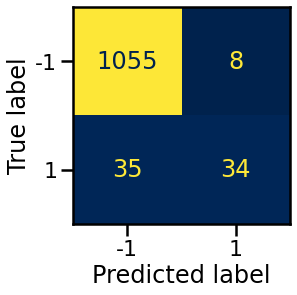

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

sns.set_context('poster')

disp = plot_confusion_matrix(clf, X_test, y_test, cmap = 'cividis', colorbar = False)


In [81]:
X_train_oversample, y_train_oversample = ros_over.fit_resample(
    X_train,
    y_train
)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


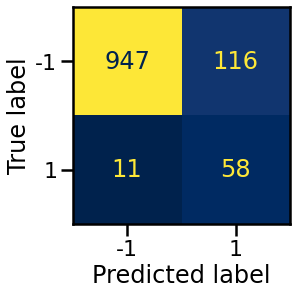

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

clf = LogisticRegression().fit(X_train_undersample, y_train_undersample)
y_pred = clf.predict(X_test)

sns.set_context('poster')

disp = plot_confusion_matrix(clf, X_test, y_test, cmap = 'cividis', colorbar = False)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


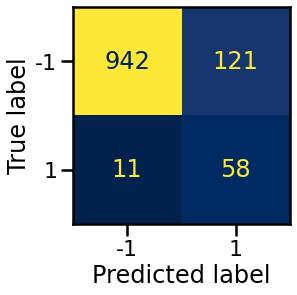

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

clf = LogisticRegression().fit(X_train_oversample, y_train_oversample)
y_pred = clf.predict(X_test)

sns.set_context('poster')

disp = plot_confusion_matrix(clf, X_test, y_test, cmap = 'cividis', colorbar = False)


## SMOTE (oversampling的一种)

In [84]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(
    X_train,
    y_train
)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


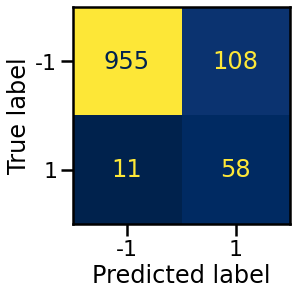

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

clf = LogisticRegression().fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)

sns.set_context('poster')

disp = plot_confusion_matrix(clf, X_test, y_test, cmap = 'cividis', colorbar = False)


## Prototype Generation

In [86]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state = 0)

X_train_cc, y_train_cc = cc.fit_resample(
    X_train,
    y_train
)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


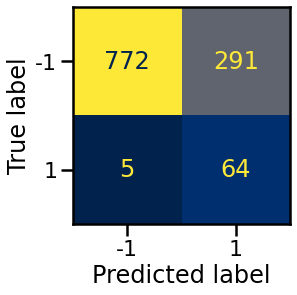

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

clf = LogisticRegression().fit(X_train_cc, y_train_cc)
y_pred = clf.predict(X_test)

sns.set_context('poster')

disp = plot_confusion_matrix(clf, X_test, y_test, cmap = 'cividis', colorbar = False)


## Ensemble Learning - Bagging & BalancedBagging

In [115]:
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier   # 比BaggingClassifier多了一步balancing training set的步骤
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# X_train_resampled, y_train_resampled = smote.fit_resample(
#     X_train,
#     y_train
# )

X_train_resampled, y_train_resampled = X_train, y_train

In [116]:
X_train.shape, X_train_resampled.shape

((2640, 52), (2640, 52))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


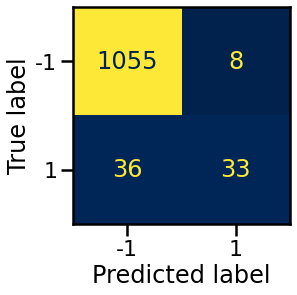

In [117]:
clf = BaggingClassifier(base_estimator=LogisticRegression(),
                                n_estimators = 10,
                                random_state = 0).fit(X_train_resampled,
                                                      y_train_resampled)


y_pred = clf.predict(X_test)

sns.set_context('poster')

disp = plot_confusion_matrix(clf, X_test, y_test, cmap = 'cividis', colorbar = False)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


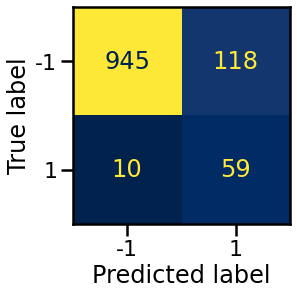

In [118]:
clf = BalancedBaggingClassifier(base_estimator=LogisticRegression(),
                                n_estimators = 10,
                                random_state = 0).fit(X_train_resampled,
                                                      y_train_resampled)


y_pred = clf.predict(X_test)

sns.set_context('poster')

disp = plot_confusion_matrix(clf, X_test, y_test, cmap = 'cividis', colorbar = False)
